In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.preprocessing import image
from PIL import Image
import io
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import random

2024-09-16 22:10:57.903142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 22:10:57.918895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 22:10:58.162282: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 22:10:58.540546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 22:10:58.805852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
base_dir = '../data_full/real-vs-fake'
#|--project
#|-----TechLabs-DL-2024
#|----------model.ipynb
#|----------README.md
#|-----real-vs-fake
#|----------test
#|----------train
#|----------valid

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

## Setting Parameters, Preprocessing and data generators

### Setting Parameters

The code begins by defining two key parameters:

- batch_size = 20 sets the number of images that will be processed at a time during training, validation, or testing.
- img_size = (150,150) resizes each image to 150x150 pixels before being input into the model, ensuring uniformity across the dataset.

### Data Preprocessing

The ImageDataGenerator(rescale=1./255) function is used to normalize the pixel values of all images by scaling them between 0 and 1. This is done by dividing each pixel value by 255. Normalization helps the model train more effectively by standardizing the input data.

### Training Data Generator

The train_generator is responsible for loading images from the train_dir, resizing them to img_size, and processing batches of 20 images at a time. It performs binary classification by categorizing the images as either ‘real’ or ‘fake’. The images are shuffled to introduce randomness into the training process, which helps prevent the model from overfitting to the data. A seed (seed=42) is set to ensure reproducibility of the shuffling across runs.

### Validation Data Generator

The valid_generator works similarly to the training data generator but loads data from the valid_dir for validation. The same image size, batch size, and binary classification process are applied. Like the training data, the validation data is also shuffled to introduce randomness during the validation process.

### Test Data Generator

The test_generator loads test data from the test_dir and prepares it for evaluation after the model is trained. However, unlike the training and validation generators, the test data is not shuffled (shuffle=False). This ensures that the model evaluates the images in a consistent order, making it easier to assess its final performance.

These data generators automate the loading, normalization, and batching of images, simplifying the process of working with large datasets in machine learning projects.

In [3]:
batch_size = 20
img_size = (150,150)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=True,
    subset=None,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=True,
    subset=None,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=False
)


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Loading our model
Below, we load our saved model and print its summary

In [4]:
from tensorflow.keras.models import load_model

# Load the model from the saved .h5 file
model = load_model('pretrained_trainable_version2_acc99.h5')

# Verify that the model is loaded correctly by printing its summary
model.summary()

/home/gparas/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,115,043 (88.18 MB)

 Trainable params: 23,080,609 (88.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 2 (12.00 B)

# Evaluating our model
In order to evaluate our model we do the following:
- we calculate the test loss and accuracy
- we predic the labels of the test images

In [5]:
# Recompile the model with the correct metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
# Now, evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
 
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/home/gparas/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 401s 392ms/step - accuracy: 0.9801 - loss: 0.0612
Test Loss: 0.06825581192970276
Test Accuracy: 0.9750999808311462


In [6]:
Y_pred_test = model.predict(test_generator)
y_pred_test = np.round(Y_pred_test).astype(int)

cm_test = confusion_matrix(test_generator.classes, y_pred_test)
print('Confusion Matrix - Test Set')
print(cm_test)

print('Classification Report - Test Set')
print(classification_report(test_generator.classes, y_pred_test, target_names=['Real', 'Fake']))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 421s 415ms/step
Confusion Matrix - Test Set
[[9821  179]
 [ 319 9681]]
Classification Report - Test Set
              precision    recall  f1-score   support

        Real       0.97      0.98      0.98     10000
        Fake       0.98      0.97      0.97     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



## Loading history
Following, we load the history to plot the accuracy and loss of the train and validation set per epoch.

In [7]:
history_df = pd.read_csv('trainable_google_layer_model.csv', index_col=0)

# Extract training history
acc = history_df['accuracy'].tolist()
val_acc = history_df['val_accuracy'].tolist()
loss = history_df['loss'].tolist()
val_loss = history_df['val_loss'].tolist()

# Get the range of epochs
epochs_range = range(len(history_df))

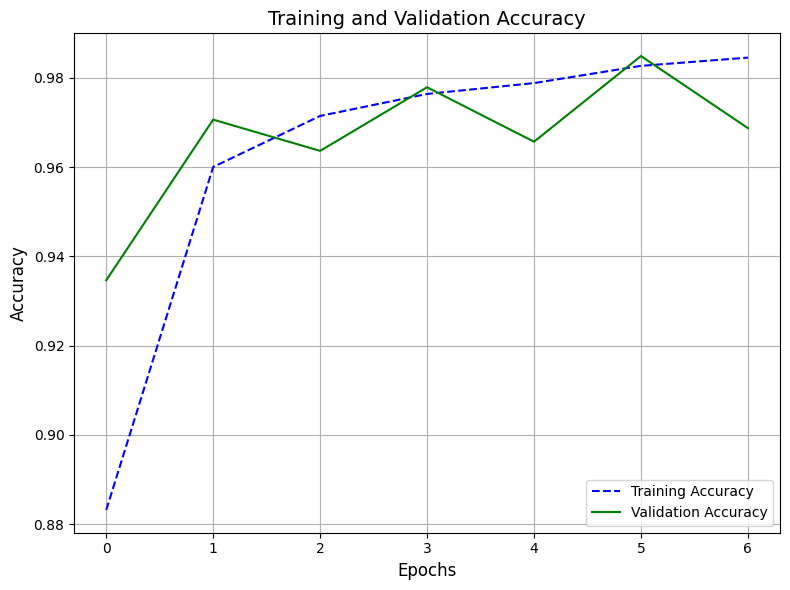

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', linestyle='--')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green', linestyle='-')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.xticks(ticks=epochs_range)  
plt.tight_layout()
plt.savefig('accuracy.png')
plt.savefig('accuracy.pdf')
plt.show()

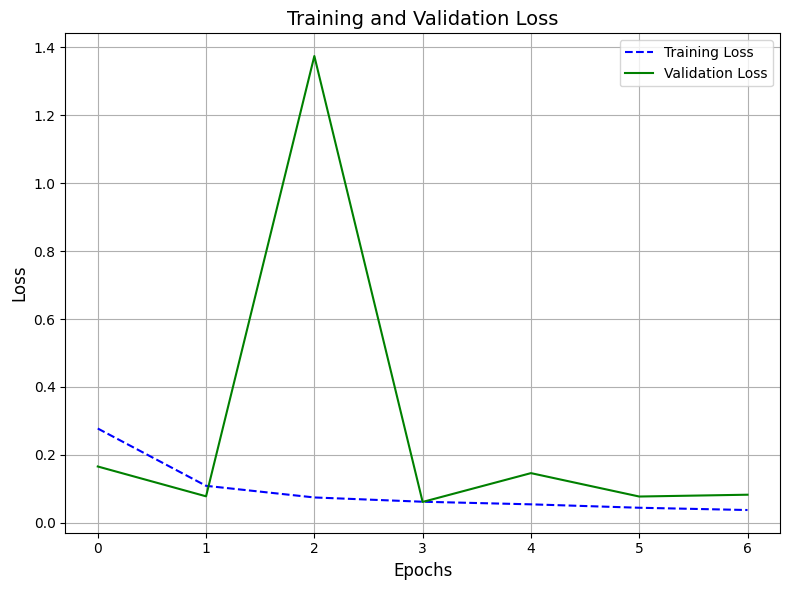

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss', color='blue', linestyle='--')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green', linestyle='-')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.xticks(ticks=epochs_range)  
plt.tight_layout()
plt.savefig('loss.png')
plt.savefig('loss.pdf')
plt.show()

## Additional plots
We implemented two more plots:
1. The confusion matrix of the test set to get a better understanding of the performance of the model
2. 9 randomly chosen images that were misclassified to get a better impression of the performance of the algorithm judging by human perspective in detection

[[9821  179]
 [ 319 9681]]


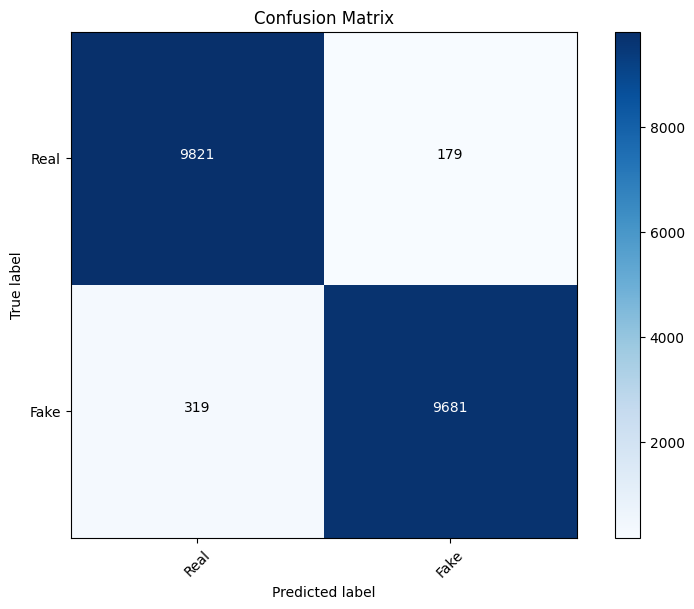

In [10]:
# Compute and visualize the confusion matrix
import itertools 
print(cm_test)
plt.figure(figsize=(8,6))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Real', 'Fake'], rotation=45)
plt.yticks(tick_marks, ['Real', 'Fake'])

# Add labels to the confusion matrix
thresh = 320  

# Add labels to the confusion matrix
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm_test[i, j] > thresh else 'black') 

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.savefig('confusion_matrix.pdf')
plt.show()

In [ ]:
# Display misclassified images
y_true = test_generator.classes
misclassified_idx = np.where(y_pred_test != y_true)[0]
random_idx = random.sample(list(misclassified_idx), 9)

label_map = {0: 'Real', 1: 'Fake'}

plt.figure(figsize=(12,12))
plt.suptitle('Misclassified Images', fontsize=16) 

for i, idx in enumerate(random_idx):  # Showing 9 random misclassified images
    plt.subplot(3,3,i+1)
    img = test_generator.filepaths[idx]
    img = image.load_img(img, target_size=(150, 150))
    plt.imshow(img)
    true_label = label_map[y_true[idx]]
    predicted_label = label_map[y_pred_classes[idx]]
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig('missclassified.png')
plt.savefig('missclassified.pdf')
plt.show()
